# Recurrent Neural Network In Binary Addition
## Abstract
This notebook is about the usage of Recurrent Neural Network (RNN) in adding two binary numbers.

## Introduction
### What is a recurrent neural network?
As far as you know, neural network is a collection of matrix operation that can approximate the connection between features and labels in a dataset. Basic neural network includes an input layer, some hidden units, and an output layer. However, because of using so much parameters, basic NN model is easily to overfit the dataset, which causes the model to have poor performances. Therefore, there are a lot of improvement to neural network; in other words, researchers are now optimizing neural network for some specific use cases. For instance, when it comes to image processing, convolutional neural network is the best model to be used. However, what if the order of each data point matter to the overall result? This is what RNN serves. Basic NN's hidden layer take the input from the previous layer to get the output; thus, it just takes fix-sized input and output fix-sized output. With the RNN, each data point is splited into time steps. At each time steps, not only does RNN take the input from the data point at the current time step, but it also takes the input from the hidden layer from the previous time step. The figure below is an illustration of RNN. Thanks to this special mechanism, RNN is perharps the best model in every dataset that the order matters.

![rnn](https://cdn-images-1.medium.com/max/1600/1*4KwIUHWL3sTyguTahIxmJw.png)

## Let's jump into code
First, we need to import our dependencies. Details about each dependency are written in the code.

In [1]:
import numpy as np # matrix operations
import matplotlib.pyplot as plt # visualization
from data import * #generate data
from activation import * # activation functions
from loss import * # loss function
from utils import * # postprocessing data

%matplotlib inline

np.random.seed(0) # help the dataset remain the same in each execution, useful for debugging

Next, we have to specify some hyperparameters. Hyperparameters are numerical value that does not include in the training process but still have a major impact on the overall performance of the model.

In [2]:
# hyperparameters
hidden_unit = 8 # number of hidden units
output_unit = 1 # number of output units
binary_bit = 4 # number of bits 
display_step = 100 # when model displays results
largest_num = 2**binary_bit-1 #the largest number with given number of bits
num_ex=50 # number of training examples we want to generate
alpha = 0.001 # learning rate
training_iter = 60000

Then, we have to randomly initialize our parameters, which are weights and biases. We will build a RNN with two input units, eight hidden units, and one output unit, so
* the weight way that connects the hidden layer with the output layer is an output unit x hidden unit matrix
* the weight wax that connects the input layer with the hidden layer is a hidden unit x input unit matrix
* the weight waa that connects the hidden layers of two consecutive hidden layers is a hidden unit x hidden unit matrix
* the bias ba that connects the input layer with the hidden layer is a column vector whose size is equal to the number of hidden unit
* the bias by that connects the hidden layer with the output layer is a column vector whose size is equal to the number of output unit

In [3]:
#parameters
wax = 2*np.random.random((hidden_unit,2)) - 1 # weight used to connect the input layer with the hidden layer
waa = 2*np.random.random((hidden_unit,hidden_unit)) - 1 # weight used to connect two consecutive hidden layers
way = 2*np.random.random((output_unit,hidden_unit)) - 1# weight used to connect the hidden layer with the output layer
ba = 2*np.random.random((hidden_unit,1)) - 1 # bias used to connect the input layer with the hidden layer
by = 2*np.random.random((output_unit,1)) - 1 # bias used to connect the hidden layer with the output layer

We also need to have a dataset. For the simplicity, we will generate the dataset by ourself. The function used to generate dataset is written in the file 'data.py'. Feel free to check that out.

In [4]:
#generate dataset
m,n,p = datagen(num_ex,binary_bit)

m_seq = np.zeros((m.shape[0],binary_bit))
n_seq = np.zeros((n.shape[0],binary_bit))
p_seq = np.zeros((p.shape[0],binary_bit))

for ex_index in range(m.shape[0]):
	m_seq[ex_index] = [float(bits) for bits in int2binary(m[ex_index][0],binary_bit)]
	n_seq[ex_index] = [float(bits) for bits in int2binary(n[ex_index][0],binary_bit)]
	p_seq[ex_index] = [float(bits) for bits in int2binary(p[ex_index][0],binary_bit)]

For the code readability, we will specify a dictionary that contains all the hidden matrix and output matrix at every time step.

In [5]:
# the hidden layer matrices
a = {0: np.zeros((hidden_unit,m.shape[0]))}

# predictions
pred = {}

Now, we are ready to step into the training step. The training process includes two steps: the forward pass and the backward pass. Each pass includes some matrix operation.

## Forward pass

$$a^{<0>}=\overrightarrow{0}$$

$$a^{<t>}=\tanh(W_{ax}x^{<t>}+W_{aa}a^{<t-1>}+b_a),\text{ }\forall t\geq 1$$

$$\widehat{y}^{<t>}=sigmoid(W_{ay}a^{<t>}+b_y),\text{ }\forall t\geq 1$$

## Backward pass (Backpropagation)
This is the process of taking the derivative of the loss function with respeact to each weight. The loss function we use here is expressed as follow:
* At the timestep $t$, $$\mathcal{L}^{<t>}(y^{<t>},\widehat{y}^{<t>})=-y^{<t>}*\log(\widehat{y}^{<t>})-(1-y^{<t>})*\log(1-\widehat{y}^{<t>})$$
* The overall loss is $$\mathcal{L}=\sum_{t}\mathcal{L}^{<t>}(y^{<t>},\widehat{y}^{<t>})$$

In the training step, we will treat each bit as input for each timestep and take the last binary bit as the first timestep. This means that the last binary bit is the input for $t=1$. We do the forward pass and then backward pass to update our parameters, making the model better and better after each iteration

In [6]:
# used to store loss (used for visualization)
err = []

# initial step
j=0

# the training loops
while j<training_iter:

	overall = 0.

	dwax = np.zeros_like(wax)
	dway = np.zeros_like(way)
	dwaa = np.zeros_like(waa)
	dba = np.zeros_like(ba)
	dby = np.zeros_like(by)

	for time in range(1,binary_bit+1):
		x = np.array([m_seq[:,binary_bit-time],n_seq[:,binary_bit-time]])
		y = np.expand_dims(p_seq[:,binary_bit-time],axis=0)

		# forward prop
		a[time] = tanh(wax.dot(x) + waa.dot(a[time-1]) + ba)
		pred[binary_bit-time] = sigmoid(way.dot(a[time]) + by)

		overall += crossentropy(pred[binary_bit-time],y)

		# backpropagation
		error = pred[binary_bit-time] - y 

		dway_update = error.dot(a[time].T)
		dby_update = np.sum(error,axis=1,keepdims=True)

		dza = way.T.dot(error)*tanh(wax.dot(x) + waa.dot(a[time-1]) + ba,deriv=True)
		dwax_update = dza.dot(x.T)
		dwaa_update = dza.dot(a[time-1].T)
		dba_update = np.sum(dza,axis=1,keepdims=True)

		dwax += dwax_update
		dwaa += dwaa_update
		dway += dway_update
		dba += dba_update
		dby += dby_update

	# store the loss at the current time step
	err.append(overall)

	# update parameters
	wax -= alpha*dwax
	waa -= alpha*dwaa
	way -= alpha*dway 
	ba -= alpha*dba 
	by -= alpha*dby

	# display the results
	if j%display_step==0:
		print('--------------------------')
		print('Iteration %d'%j)
		print('Loss %s'%overall)
		test = np.random.randint(m.shape[0])
		prediction = [int(pred[i][0,test] >= 0.5) for i in range(binary_bit)]
		print('%d + %d = %d'%(int(m[test]),int(n[test]),binary2int(prediction)))
		print('--------------------------')

	j+=1

--------------------------
Iteration 0
Loss 150.21906399989592
6 + 0 = 15
--------------------------
--------------------------
Iteration 100
Loss 117.89824102412551
4 + 3 = 15
--------------------------
--------------------------
Iteration 200
Loss 102.22051138856696
0 + 0 = 0
--------------------------
--------------------------
Iteration 300
Loss 81.96352804125291
3 + 1 = 6
--------------------------
--------------------------
Iteration 400
Loss 55.937760933602334
1 + 6 = 7
--------------------------
--------------------------
Iteration 500
Loss 38.8359694359998
4 + 2 = 6
--------------------------
--------------------------
Iteration 600
Loss 30.14246265269674
5 + 5 = 10
--------------------------
--------------------------
Iteration 700
Loss 25.193730075103062
6 + 5 = 11
--------------------------
--------------------------
Iteration 800
Loss 22.23983795275349
5 + 2 = 7
--------------------------
--------------------------
Iteration 900
Loss 20.23025494320608
1 + 1 = 2
-----------

--------------------------
Iteration 8400
Loss 2.4095199201444144
4 + 0 = 4
--------------------------
--------------------------
Iteration 8500
Loss 2.402896244915741
6 + 3 = 9
--------------------------
--------------------------
Iteration 8600
Loss 2.396440198605898
6 + 5 = 11
--------------------------
--------------------------
Iteration 8700
Loss 2.390145274752779
4 + 2 = 6
--------------------------
--------------------------
Iteration 8800
Loss 2.38400530061891
6 + 1 = 7
--------------------------
--------------------------
Iteration 8900
Loss 2.3780144163891213
2 + 2 = 4
--------------------------
--------------------------
Iteration 9000
Loss 2.372167055882581
3 + 1 = 4
--------------------------
--------------------------
Iteration 9100
Loss 2.3664579286515037
2 + 0 = 2
--------------------------
--------------------------
Iteration 9200
Loss 2.360882003351306
4 + 3 = 7
--------------------------
--------------------------
Iteration 9300
Loss 2.3554344922776638
2 + 2 = 4
---

--------------------------
Iteration 16400
Loss 2.1423651112309714
5 + 5 = 10
--------------------------
--------------------------
Iteration 16500
Loss 2.1406557748475508
5 + 0 = 5
--------------------------
--------------------------
Iteration 16600
Loss 2.138964120764246
6 + 5 = 11
--------------------------
--------------------------
Iteration 16700
Loss 2.137289638031816
0 + 0 = 0
--------------------------
--------------------------
Iteration 16800
Loss 2.1356318156423284
1 + 1 = 2
--------------------------
--------------------------
Iteration 16900
Loss 2.1339901415285154
4 + 0 = 4
--------------------------
--------------------------
Iteration 17000
Loss 2.1323641014988977
6 + 6 = 8
--------------------------
--------------------------
Iteration 17100
Loss 2.130753178098948
2 + 2 = 4
--------------------------
--------------------------
Iteration 17200
Loss 2.129156849387578
3 + 0 = 3
--------------------------
--------------------------
Iteration 17300
Loss 2.1275745876164964

--------------------------
Iteration 24700
Loss 0.5469478945067734
0 + 4 = 4
--------------------------
--------------------------
Iteration 24800
Loss 0.5310443950353999
6 + 5 = 11
--------------------------
--------------------------
Iteration 24900
Loss 0.5163131160663077
6 + 3 = 9
--------------------------
--------------------------
Iteration 25000
Loss 0.5025998763724363
5 + 5 = 10
--------------------------
--------------------------
Iteration 25100
Loss 0.48977969404607546
5 + 2 = 7
--------------------------
--------------------------
Iteration 25200
Loss 0.47774984094049683
5 + 6 = 11
--------------------------
--------------------------
Iteration 25300
Loss 0.46642480885313775
6 + 4 = 10
--------------------------
--------------------------
Iteration 25400
Loss 0.45573260870949933
0 + 5 = 5
--------------------------
--------------------------
Iteration 25500
Loss 0.44561201036655507
4 + 0 = 4
--------------------------
--------------------------
Iteration 25600
Loss 0.43601

--------------------------
Iteration 33000
Loss 0.1789785817133877
6 + 4 = 10
--------------------------
--------------------------
Iteration 33100
Loss 0.17763644989197047
6 + 3 = 9
--------------------------
--------------------------
Iteration 33200
Loss 0.176315509756925
3 + 6 = 9
--------------------------
--------------------------
Iteration 33300
Loss 0.1750152521795291
4 + 0 = 4
--------------------------
--------------------------
Iteration 33400
Loss 0.17373518439398758
0 + 4 = 4
--------------------------
--------------------------
Iteration 33500
Loss 0.17247482933574038
5 + 0 = 5
--------------------------
--------------------------
Iteration 33600
Loss 0.17123372501233944
3 + 0 = 3
--------------------------
--------------------------
Iteration 33700
Loss 0.17001142390503024
1 + 6 = 7
--------------------------
--------------------------
Iteration 33800
Loss 0.16880749239928713
6 + 5 = 11
--------------------------
--------------------------
Iteration 33900
Loss 0.1676215

--------------------------
Iteration 40900
Loss 0.11328222737114356
6 + 0 = 6
--------------------------
--------------------------
Iteration 41000
Loss 0.1127705932887085
3 + 1 = 4
--------------------------
--------------------------
Iteration 41100
Loss 0.11226379901018368
3 + 1 = 4
--------------------------
--------------------------
Iteration 41200
Loss 0.11176177455491945
0 + 3 = 3
--------------------------
--------------------------
Iteration 41300
Loss 0.11126445130351738
0 + 5 = 5
--------------------------
--------------------------
Iteration 41400
Loss 0.11077176196462502
2 + 3 = 5
--------------------------
--------------------------
Iteration 41500
Loss 0.11028364054274814
3 + 0 = 3
--------------------------
--------------------------
Iteration 41600
Loss 0.10980002230698133
2 + 2 = 4
--------------------------
--------------------------
Iteration 41700
Loss 0.10932084376062587
6 + 4 = 10
--------------------------
--------------------------
Iteration 41800
Loss 0.10884

--------------------------
Iteration 48900
Loss 0.08346488503692878
5 + 6 = 11
--------------------------
--------------------------
Iteration 49000
Loss 0.08319495140196496
2 + 2 = 4
--------------------------
--------------------------
Iteration 49100
Loss 0.08292683687607103
3 + 0 = 3
--------------------------
--------------------------
Iteration 49200
Loss 0.08266052276073116
3 + 6 = 9
--------------------------
--------------------------
Iteration 49300
Loss 0.08239599061601283
0 + 0 = 0
--------------------------
--------------------------
Iteration 49400
Loss 0.0821332222560406
5 + 2 = 7
--------------------------
--------------------------
Iteration 49500
Loss 0.08187219974460863
5 + 5 = 10
--------------------------
--------------------------
Iteration 49600
Loss 0.08161290539088242
5 + 6 = 11
--------------------------
--------------------------
Iteration 49700
Loss 0.08135532174515388
0 + 5 = 5
--------------------------
--------------------------
Iteration 49800
Loss 0.081

Loss 0.06674356746656326
0 + 0 = 0
--------------------------
--------------------------
Iteration 56800
Loss 0.06657415958197467
6 + 5 = 11
--------------------------
--------------------------
Iteration 56900
Loss 0.06640564492069301
0 + 3 = 3
--------------------------
--------------------------
Iteration 57000
Loss 0.06623801630685333
5 + 5 = 10
--------------------------
--------------------------
Iteration 57100
Loss 0.06607126664202878
5 + 5 = 10
--------------------------
--------------------------
Iteration 57200
Loss 0.06590538890420115
0 + 4 = 4
--------------------------
--------------------------
Iteration 57300
Loss 0.0657403761467239
6 + 4 = 10
--------------------------
--------------------------
Iteration 57400
Loss 0.06557622149730499
3 + 0 = 3
--------------------------
--------------------------
Iteration 57500
Loss 0.06541291815698377
6 + 3 = 9
--------------------------
--------------------------
Iteration 57600
Loss 0.06525045939919401
6 + 0 = 6
-----------------

As can be seen from the result, at first, the model makes a silly guest; for example, $6+0=15$. However, after 200 iterations, the model is significantly improved and makes a logical prediction. The graph below shows the performance of the model at each iteration

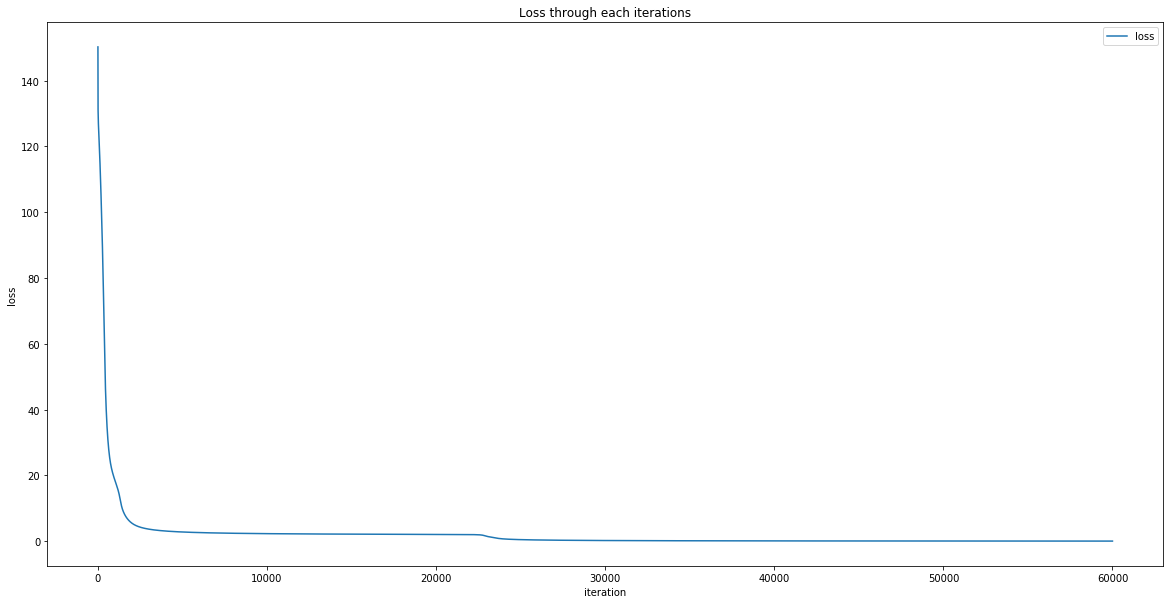

In [7]:
#visualize the results
plt.figure(figsize=(20,10))
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Loss through each iterations')
plt.plot(np.arange(1,1+len(err)),err,label='loss')
plt.legend()
plt.show()